# Model training

Libraries

In [1]:
import cv2 as cv
import numpy as np
import pandas as pd
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image as im
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.models import Sequential, Model
import pickle

from keras import backend as K
from tensorflow.keras.optimizers import SGD, Adam, Adagrad, RMSprop
import matplotlib.pyplot as plt
import pandas as pd
import numpy
import time
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
data_dir = "base"
batch_size = 16

In [32]:
train_datagen = im.ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.1)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    data_dir,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # set as validation data

Found 956 images belonging to 12 classes.
Found 100 images belonging to 12 classes.


In [4]:
save_dir = os.path.join(os.getcwd(), 'trained_models')
if not os.path.isdir(save_dir):
  os.makedirs(save_dir)

print(save_dir)

R:\projects\labvit\azulejos_ml\trained_models


Model definition function

In [5]:
def model_def(view_model=False):
    
    K.clear_session()
    
    input_shape = (256, 256, 3) # Corrige o erro do tensorflow no carregamento do modelo treinado
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(64, (3,3), padding="same", activation="relu", input_shape=input_shape),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(64, (3,3), padding="same", activation="relu"),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(32, (3,3), padding="same", activation="relu"),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(32, (3,3), padding="same", activation="relu"),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(16, (3,3), padding="same", activation="relu"),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(16, (3,3), padding="same", activation="relu"),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(16, (3,3), padding="same", activation="relu"),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1024, activation="relu"), # 64
        tf.keras.layers.Dense(512, activation="relu"), # 32
        tf.keras.layers.Dense(128, activation="relu"), # 32
        tf.keras.layers.Dense(12, activation="softmax")])
    
    if view_model:
        model.summary()
    
    return model

Callbacks definition function

In [6]:
def callback_func(opt=None, nb_epochs=50, verbose=0):
    
    dir_name = opt.lower()+'_'+str(nb_epochs)+'_epochs'
    checkpoint_path = os.path.join(save_dir, dir_name, 'cp-{epoch:04d}.ckpt')
    checkpoint_dir = os.path.dirname(checkpoint_path)
    
    if not os.path.isdir(checkpoint_dir):
        os.makedirs(checkpoint_dir)
        
    cp1_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        verbose=verbose,
        save_weights_only=True,
        #save_freq=60
        monitor='val_accuracy',
        save_best_only=True
      )
  
    cp2_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        verbose=verbose,
        save_weights_only=True,
        #save_freq=60
        monitor='val_loss',
        save_best_only=True
      )
  
    callbakcs_list = [cp1_callback, cp2_callback]

    return callbakcs_list, checkpoint_dir

Model and callbacks save function

In [7]:
def save_func(opt=None, model=None, history=None, checkpoint_dir=None, nb_epochs=50):
    
    file_name = opt.lower()+'_'+str(nb_epochs)+'_epochs'
    model_name = file_name+'.h5'
  
    model_path = os.path.join(save_dir, checkpoint_dir, model_name)
    model.save(model_path)
    print('Saved trained model at %s ' % model_path)

    if len(history.keys())>2: # validation
        np.savez(os.path.join(save_dir, checkpoint_dir, file_name+'_history'), accuracy=history['accuracy'], loss=history['loss'], val_accuracy=history['val_accuracy'], val_loss=history['val_loss'])
    else:
        np.savez(os.path.join(save_dir, checkpoint_dir, file_name+'_history'), accuracy=history['accuracy'], loss=history['loss'])

    return 0

Model parameters function

In [8]:
def model_params(opt = 'RMSprop(learning_rate=0.0001)', nb_epochs = 50, callback=True, save_model=True):
    
    model = model_def()
    
    model.compile(optimizer=eval(opt),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    
    if callback:
        cp_callback, checkpoint_dir = callback_func(opt, nb_epochs)

    start_time = time.time()
    history = model.fit(train_generator,
                        steps_per_epoch = len(train_generator),
                        validation_data = validation_generator,
                        validation_steps = len(validation_generator),
                        epochs = nb_epochs,
                        callbacks=[cp_callback])
    training_time = time.time() - start_time
    
    print("\n--- Training time: %s seconds ---" % training_time)

    val_loss, val_acc = model.evaluate(validation_generator, steps=len(validation_generator))
    
    if save_model==True:
        save_func(opt, model, history.history, checkpoint_dir, nb_epochs)

    return val_loss, val_acc, history.history, model

Main loop to run different params

In [13]:
#opts = ['RMSprop(learning_rate=0.0001)',
 #      'RMSprop(learning_rate=0.0005)',
  #     'RMSprop(learning_rate=0.001)',
   #    'RMSprop(learning_rate=0.005)']

#opts = ['SGD(learning_rate=0.001)',
 #      'SGD(learning_rate=0.005)',
  #     'SGD(learning_rate=0.01)',
   #    'SGD(learning_rate=0.05)']

opts = ['RMSprop(learning_rate=0.0001)',
        'SGD(learning_rate=0.005)']

#opts = ['SGD(learning_rate=0.005)']

nb_epochs = 50

val_loss_list = []
val_acc_list = []
h_list = []
model_list = []

for opt in opts:
    
    print(opt)
    
    val_loss, val_acc, h, model = model_params(opt=opt, nb_epochs=nb_epochs, save_model=True)
    
    print('\n')
    
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
    h_list.append(h)
    model_list.append(model)

RMSprop(learning_rate=0.0001)
Epoch 1/50
60/60 [==============================] - 60s 993ms/step - loss: 2.3982 - accuracy: 0.1831 - val_loss: 2.1782 - val_accuracy: 0.2700
Epoch 2/50
60/60 [==============================] - 62s 1s/step - loss: 2.0804 - accuracy: 0.2824 - val_loss: 1.9524 - val_accuracy: 0.3500
Epoch 3/50
60/60 [==============================] - 59s 989ms/step - loss: 1.8321 - accuracy: 0.3902 - val_loss: 1.6143 - val_accuracy: 0.4500
Epoch 4/50
60/60 [==============================] - 60s 1s/step - loss: 1.6159 - accuracy: 0.4320 - val_loss: 1.3268 - val_accuracy: 0.5300
Epoch 5/50
60/60 [==============================] - 58s 961ms/step - loss: 1.5421 - accuracy: 0.4749 - val_loss: 1.3046 - val_accuracy: 0.5700
Epoch 6/50
60/60 [==============================] - 58s 968ms/step - loss: 1.4319 - accuracy: 0.5021 - val_loss: 1.3170 - val_accuracy: 0.5600
Epoch 7/50
60/60 [==============================] - 60s 995ms/step - loss: 1.3534 - accuracy: 0.5345 - val_loss: 1.196

Epoch 6/50
60/60 [==============================] - 53s 884ms/step - loss: 1.7166 - accuracy: 0.3828 - val_loss: 1.5036 - val_accuracy: 0.4500
Epoch 7/50
60/60 [==============================] - 53s 884ms/step - loss: 1.6277 - accuracy: 0.4184 - val_loss: 1.5371 - val_accuracy: 0.4500
Epoch 8/50
60/60 [==============================] - 53s 888ms/step - loss: 1.5215 - accuracy: 0.4592 - val_loss: 1.3047 - val_accuracy: 0.6000
Epoch 9/50
60/60 [==============================] - 53s 886ms/step - loss: 1.4563 - accuracy: 0.4791 - val_loss: 1.4521 - val_accuracy: 0.5000
Epoch 10/50
60/60 [==============================] - 53s 886ms/step - loss: 1.3866 - accuracy: 0.5157 - val_loss: 1.4183 - val_accuracy: 0.4900
Epoch 11/50
60/60 [==============================] - 53s 883ms/step - loss: 1.3167 - accuracy: 0.5356 - val_loss: 1.4212 - val_accuracy: 0.5400
Epoch 12/50
60/60 [==============================] - 53s 882ms/step - loss: 1.2567 - accuracy: 0.5460 - val_loss: 1.0224 - val_accuracy: 0.5

In [14]:
dflist = []
myDict = {}

for i in range(len(opts)):
    x = np.array(val_acc_list[i])
    dflist.append(pd.Series(x))
    myDict[i] = opts[i]

df = pd.concat(dflist, axis=1)    

#df.rename(columns={0:opt[0], 1:opt[1], 2:opt[2], 3:opt[3]}, index={0:'Accuracy'}).T
df = df.rename(columns=myDict, index={0:'Accuracy'}).T

#df.to_excel(os.path.join(result_dir, 'teste_acc.xlsx'))
df.head()

,Accuracy
RMSprop(learning_rate=0.0001),0.7599999904632568
SGD(learning_rate=0.005),0.8399999737739563


In [15]:
dflist = []
myDict = {}

for i in range(len(opts)):
    x = np.array(val_loss_list[i])
    dflist.append(pd.Series(x))
    myDict[i] = opts[i]

df = pd.concat(dflist, axis=1)

df = df.rename(columns=myDict, index={0:'Loss'}).T

#df.to_excel(os.path.join(result_dir, 'teste_loss.xlsx'))
df.head()

,Loss
RMSprop(learning_rate=0.0001),0.8391794562339783
SGD(learning_rate=0.005),0.5163215398788452


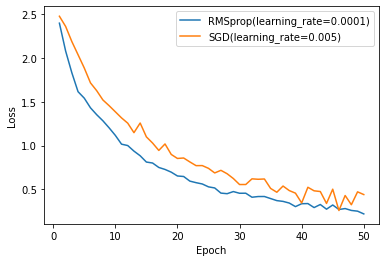

In [16]:
x = np.arange(1, np.size(h_list[0]['accuracy'])+1)

for i in range(len(opts)):
    plt.plot(x, h_list[i]['loss'])

plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(opts, loc='best')
#plt.savefig(os.path.join(result_dir, 'teste_loss_plot.png'), dpi=300)
plt.show()

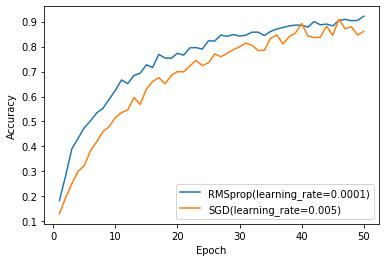

In [17]:
x = np.arange(1, np.size(h_list[0]['accuracy'])+1)

for i in range(len(opts)):
    plt.plot(x, h_list[i]['accuracy'])

plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(opts, loc='best')
#plt.savefig(os.path.join(result_dir, 'teste_acc_plot.png'), dpi=300)
plt.show()

# Evaluation and results of the model

Load history of saved model

In [3]:
dir_name = 'trained_models\sgd(learning_rate=0.005)_500_epochs'

In [4]:
data_name = 'sgd(learning_rate=0.005)_500_epochs_history.npz'

In [5]:
data = np.load(os.path.join(dir_name, data_name))

x = np.arange(1, np.size(data['accuracy'])+1)

print(data.files)

['accuracy', 'loss', 'val_accuracy', 'val_loss']


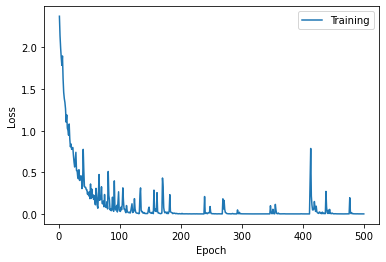

In [6]:
plt.plot(x, data['loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training'], loc='best')
plt.show()

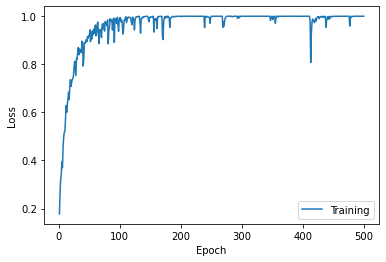

In [7]:
plt.plot(x, data['accuracy'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training'], loc='best')
plt.show()

In [8]:
train_datagen = im.ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.1
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    data_dir,
    batch_size=batch_size,
    shuffle=False, 
    class_mode='categorical',
    subset='validation') # set as validation data

Found 956 images belonging to 12 classes.
Found 100 images belonging to 12 classes.


Loading of model

In [9]:
model_name = 'sgd(learning_rate=0.005)_500_epochs.h5'

In [10]:
model = load_model(os.path.join(dir_name, model_name))

In [11]:
model.input_shape

(None, 256, 256, 3)

Loading of model weights

In [12]:
weights_name = 'cp-0485.ckpt'

In [13]:
model.load_weights(os.path.join(dir_name, weights_name))

In [14]:
loss, acc = model.evaluate(validation_generator, verbose=2)

7/7 - 2s - loss: 0.3538 - accuracy: 0.9600


In [15]:
print('Acurracy: %.2f%%' % (acc*100))
print('Loss: %.4f' % loss)

Acurracy: 96.00%
Loss: 0.3538


# TF Lite Conversion

In [17]:
#model._set_inputs(tf.keras.Input((299,299,3)))
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open("trained_models/" + 'model_sgd.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\rafae\AppData\Local\Temp\tmpz2ix9pfd\assets


INFO:tensorflow:Assets written to: C:\Users\rafae\AppData\Local\Temp\tmpz2ix9pfd\assets


# CSV file

In [18]:
history_files = data.files
print(history_files)

['accuracy', 'loss', 'val_accuracy', 'val_loss']


Create dict and DataFrame

In [19]:
myDict = {}
for name in history_files:
    myDict[name] = data[name]

df_history = pd.DataFrame(myDict)
df_history.head()

,accuracy,loss,val_accuracy,val_loss
0,0.177824,2.374631,0.15,2.275398
1,0.261506,2.139382,0.37,1.938977
2,0.320084,1.993228,0.32,1.885215
3,0.341004,1.876089,0.40,1.840134
4,0.394351,1.784726,0.29,1.850431


Save history DataFrame

In [20]:
df_history.to_csv(os.path.join(dir_name, data_name[:-3]+'csv'), index=False)

Read saved csv file

In [21]:
df_test = pd.read_csv(os.path.join(dir_name, data_name[:-3]+'csv'))
df_test.head()

,accuracy,loss,val_accuracy,val_loss
0,0.177824,2.374631,0.15,2.275398
1,0.261506,2.139382,0.37,1.938977
2,0.320084,1.993228,0.32,1.885215
3,0.341004,1.876089,0.40,1.840134
4,0.394351,1.784726,0.29,1.850431


# Confusion matrix and classification report

In [22]:
pred = model.predict(validation_generator)

In [23]:
pred.shape

(100, 12)

In [24]:
cm = confusion_matrix(validation_generator.classes, np.argmax(pred, axis=1))
print(cm)

[[ 8  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  7  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  8  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 12  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  7  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  7  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 11  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  7  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  9  0  1]
 [ 0  0  1  0  0  0  0  0  0  0  3  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  7]]


In [25]:
validation_generator.class_indices

{'casaache': 0,
 'fotoativa': 1,
 'ihgp': 2,
 'largoredondo': 3,
 'mercado': 4,
 'particular1': 5,
 'particular2': 6,
 'pinho': 7,
 'pizzeria': 8,
 'sesc': 9,
 'soberano': 10,
 'tomazia': 11}

In [26]:
target_names = ['casaache',
                'fotoativa',
                'ihgp',
                'largoredondo',
                'mercado',
                'particular1',
                'particular2',
                'pinho',
                'pizzeria',
                'sesc',
                'soberano',
                'tomazia']

In [27]:
def plot_cm(cm, classes, cmap=plt.cm.Blues, normalize = False, fig_dir=''):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = cm*100
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots(dpi=150)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
    #       title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    #plt.savefig(os.path.join(fig_dir, 'confusion_matrix.png'), bbox_inches = 'tight')
    plt.savefig(os.path.join(fig_dir, 'confusion_matrix.pdf'), bbox_inches = 'tight')
    return None

Confusion matrix, without normalization


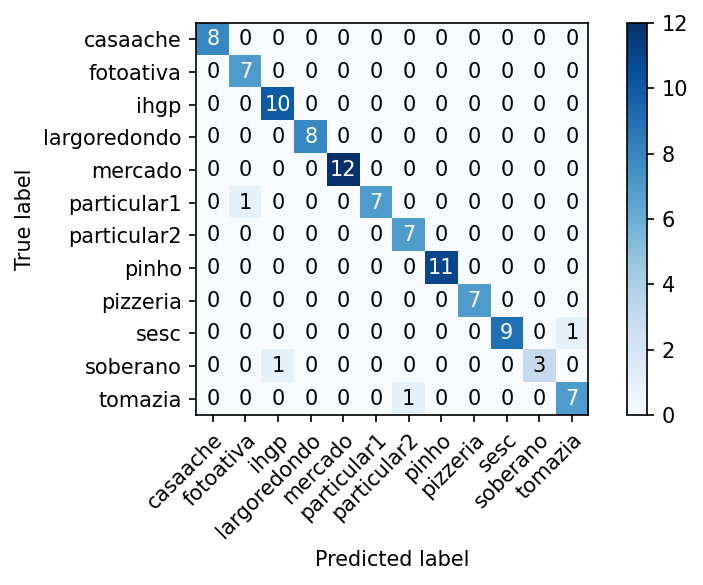

In [28]:
plot_cm(cm, classes=target_names, normalize=False, fig_dir=dir_name)

In [29]:
print(classification_report(validation_generator.classes, np.argmax(pred, axis=1), target_names=target_names))

              precision    recall  f1-score   support

    casaache       1.00      1.00      1.00         8
   fotoativa       0.88      1.00      0.93         7
        ihgp       0.91      1.00      0.95        10
largoredondo       1.00      1.00      1.00         8
     mercado       1.00      1.00      1.00        12
 particular1       1.00      0.88      0.93         8
 particular2       0.88      1.00      0.93         7
       pinho       1.00      1.00      1.00        11
    pizzeria       1.00      1.00      1.00         7
        sesc       1.00      0.90      0.95        10
    soberano       1.00      0.75      0.86         4
     tomazia       0.88      0.88      0.88         8

    accuracy                           0.96       100
   macro avg       0.96      0.95      0.95       100
weighted avg       0.96      0.96      0.96       100

